## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%.

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
base_path = "/content/drive/MyDrive/UCI HAR Dataset/UCI HAR Dataset"
%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)).

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

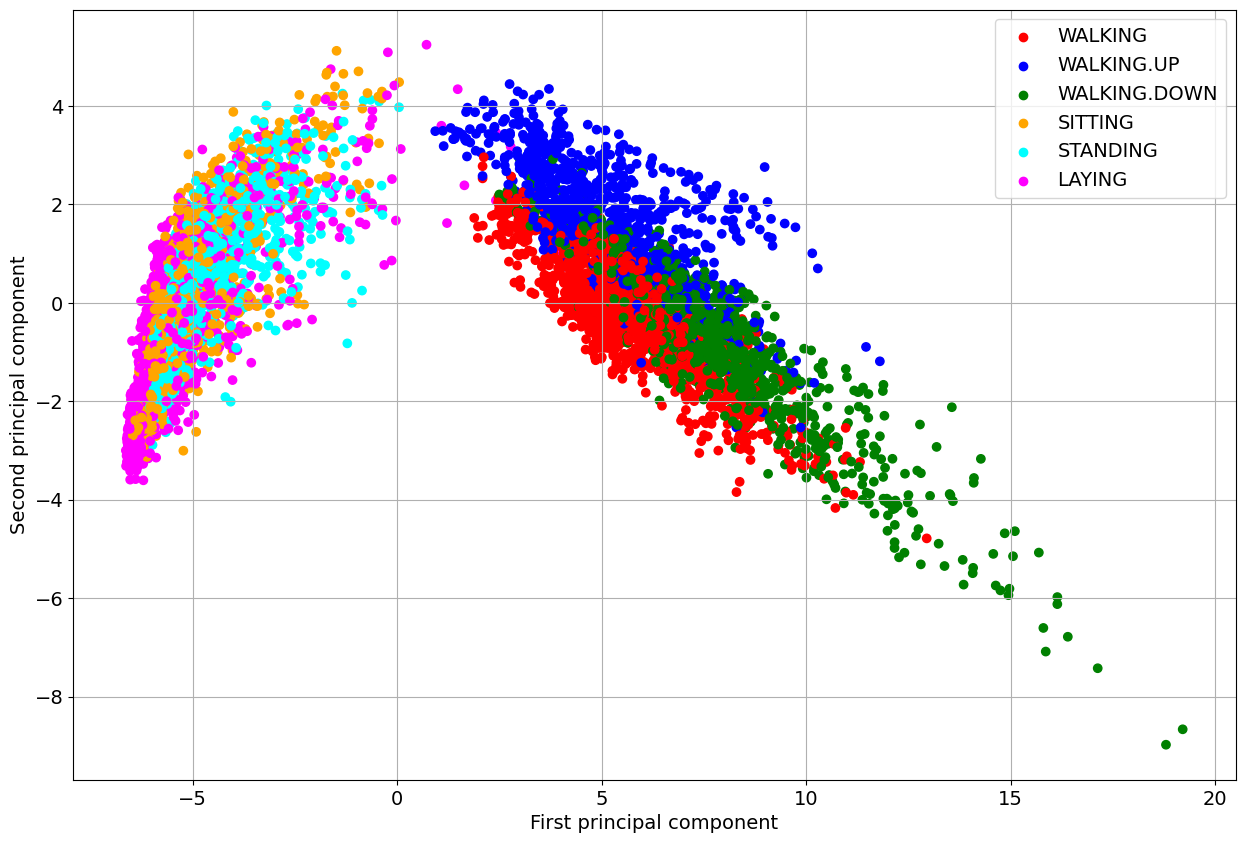

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join(base_path, "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join(base_path, "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0],
                x[1],
                c=colors_list[idx],
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
signal_path = "/content/drive/MyDrive/UCI HAR Dataset/UCI HAR Dataset/train/Inertial Signals/"
print("Files in directory:", os.listdir(signal_path))

Files in directory: ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 'total_acc_y_train.txt', 'total_acc_x_train.txt', 'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt']


In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATA_PATH = "/content/drive/MyDrive/UCI HAR Dataset/UCI HAR Dataset/"

DATASET_PATH = DATA_PATH
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: /content/drive/MyDrive/UCI HAR Dataset/UCI HAR Dataset/


In [ ]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
# Your experiments here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
#попробуем ранюю остановку
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Метрика для отслеживания
    patience=20,              # Количество эпох без улучшения перед остановкой
    verbose=1,
    restore_best_weights=True,  # Восстановить веса с лучшей эпохи
    mode='max',  # Ожидается максимизация метрики
    baseline=0.91  # Минимальная цель 91%
)

In [ ]:
# Определение модели
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.15), #
    LSTM(128, return_sequences=True),
    Dropout(0.15),
    LSTM(128, return_sequences=False),
    Dropout(0.15),
    Dense(n_classes, activation='softmax', kernel_regularizer=l2(0.01)) #добавил л2 регул
])

# Компиляция модели
model.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=n_classes)
y_test_one_hot = to_categorical(y_test, num_classes=n_classes)

In [ ]:
# Обучение
history = model.fit(
    X_train, y_train_one_hot,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]  # Добавляем колбэк
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4505 - loss: 1.3596 - val_accuracy: 0.6744 - val_loss: 0.9682
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7466 - loss: 0.7198 - val_accuracy: 0.8246 - val_loss: 0.6618
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8796 - loss: 0.4394 - val_accuracy: 0.9014 - val_loss: 0.4409
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9354 - loss: 0.2563 - val_accuracy: 0.8810 - val_loss: 0.4229
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9437 - loss: 0.2282 - val_accuracy: 0.8858 - val_loss: 0.3927
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9459 - loss: 0.1900 - val_accuracy: 0.8953 - val_loss: 0.3636
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9511 - loss: 0.1910 - val_accuracy: 0.8973 - val_loss: 0.3730
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9559 - loss: 0.1599 - val_accuracy: 0.9062 - v

In [ ]:
# Оценка модели
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8758 - loss: 0.3102
Test Accuracy: 91.52%


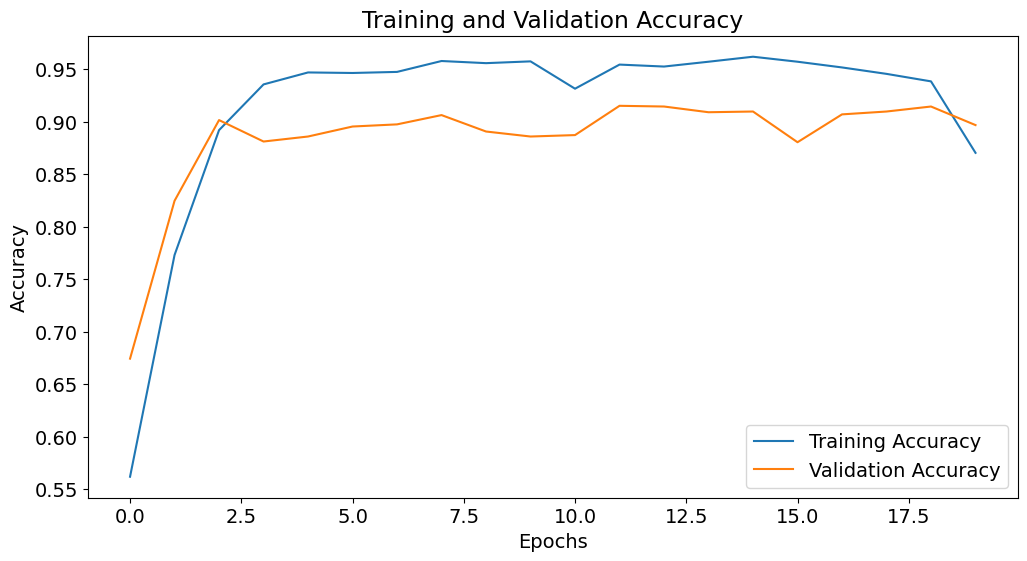

In [ ]:
# Визуализация истории
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Для обработки временных рядов выбрал модель типа LSTM, состоящую из ЛСТМ слоев, слоев дропаут для регуляризации и полносвязный слой с софтмаксом для классификации.

Для оптимизации пробовал Адама, но в итоге пришел к доп ускорению Нестерова, чтобы обучалась быстрее.

Для целей повышения точности увеличивал число слоев (с 2х до 3х) и нейронов в слое с 32 до 128. Уменьшал дропаут в итоге до 0.15. Добавил L2 регуляризацию с константой 0.01.

И, наверное, самое главное что помогло - включил раннюю остановку, чтобы модель запомнила лучшие параметры на 20 эпохах и использовала их как окончательные. Это позволило достичь точности на валидационной выборке более 91%

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [14]:
import os
import requests
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from PIL import Image

In [2]:
!pip install requests zipfile36

In [3]:
import os
import requests
import zipfile

# URL для скачивания
url = "https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=1"  # Обратите внимание, что `dl=0` заменен на `dl=1` для прямого скачивания

# Папка для данных
data_dir = "./data"
zip_path = "./data.zip"

# Создаем папку для данных, если она не существует
os.makedirs(data_dir, exist_ok=True)

# Загрузка файла
if not os.path.exists(zip_path):
    print("Скачивание данных...")
    response = requests.get(url, stream=True)
    with open(zip_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
    print("Данные скачаны!")

# Распаковка архива
if not os.listdir(data_dir):
    print("Распаковка данных...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(data_dir)
    print("Данные распакованы!")

Скачивание данных...
Данные скачаны!
Распаковка данных...
Данные распакованы!


In [4]:
# Пути к данным

train_dir = "/content/data/data/train"
test_dir = "/content/data/data/test"
os.makedirs(data_dir, exist_ok=True)

In [34]:
image_size = 224
# Трансформации
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [35]:
batch_size = 32
# Обучающая выборка
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Гиперпараметры

num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Тестовая выборка
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.images = sorted(os.listdir(root))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, self.images[idx]

test_dataset = TestDataset(test_dir, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

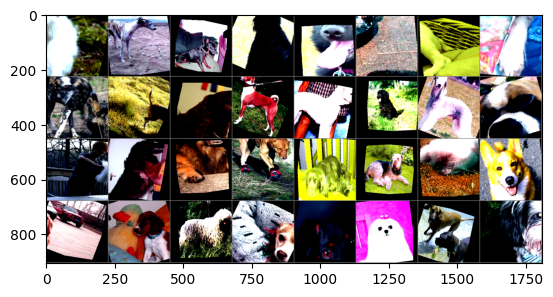

Классы: tensor([42, 11,  0, 29, 27, 40, 14, 37, 47, 40, 36, 33, 13, 49, 13,  3, 48, 35,
        35, 17, 20, 30, 48, 38, 25, 37, 28, 46,  0, 18, 21,  8])


In [16]:
# Просмотр нескольких примеров из обучающей выборки
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets, transforms

def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Показать изображения из train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print("Классы:", labels)

In [36]:
# Проверка дисбаланса классов
class_counts = [train_dataset.targets.count(c) for c in range(len(train_dataset.classes))]
print("Распределение классов:", class_counts)

Распределение классов: [151, 126, 129, 139, 123, 137, 153, 142, 174, 143, 139, 154, 129, 148, 128, 126, 123, 137, 252, 151, 125, 120, 122, 124, 161, 122, 125, 124, 124, 195, 165, 197, 176, 170, 144, 169, 131, 123, 155, 123, 128, 155, 139, 122, 129, 133, 124, 138, 174, 125]


In [37]:
# Генерация весов для устранения дисбаланса
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

In [38]:
# Генерация весов для устранения дисбаланса
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for label in train_dataset.targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

batch_size = 32

# Разделяем обучающую и валидационную выборки
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Тестовый DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [20]:
print("Количество классов в train_dataset:", len(train_dataset.classes))
print("Классы:", train_dataset.classes)

Количество классов в train_dataset: 50
Классы: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7', '8', '9']


In [43]:
from torchvision.models import resnet50

model = resnet50(pretrained=True)
for name, param in model.named_parameters():
    if "layer4" in name or "layer3" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Замена последнего слоя
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes)
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [44]:
# Функция потерь
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    #{'params': model.layer3.parameters(), 'lr': 0.00005},
    #{'params': model.layer4.parameters(), 'lr': 0.0001},
    {'params': model.fc.parameters(), 'lr': 0.001}
])

# Планировщик
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Каждая эпоха имеет обучающую и валидационную фазу
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Режим обучения
                dataloader = train_loader
            else:
                model.eval()   # Режим валидации
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Итерация по данным
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Обнуление градиентов
                optimizer.zero_grad()

                # Прямой проход
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Обратное распространение + оптимизация только на обучении
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Планировщик шага
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Потеря: {epoch_loss:.4f} Точность: {epoch_acc:.4f}")

            # Сохранение лучшей модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f"Лучший результат на валидации: {best_acc:.4f}")

    # Загрузка лучших весов модели
    model.load_state_dict(best_model_wts)
    return model

In [46]:
# Запускаем тренировку
trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Эпоха 1/20
----------
train Потеря: 1.6324 Точность: 0.6429
val Потеря: 0.7801 Точность: 0.7929
Эпоха 2/20
----------
train Потеря: 0.7445 Точность: 0.8077
val Потеря: 0.6378 Точность: 0.8236
Эпоха 3/20
----------
train Потеря: 0.6277 Точность: 0.8233
val Потеря: 0.6021 Точность: 0.8305
Эпоха 4/20
----------
train Потеря: 0.6442 Точность: 0.8172
val Потеря: 0.6182 Точность: 0.8215
Эпоха 5/20
----------
train Потеря: 0.5984 Точность: 0.8308
val Потеря: 0.6450 Точность: 0.8257
Эпоха 6/20
----------
train Потеря: 0.5561 Точность: 0.8381
val Потеря: 0.6181 Точность: 0.8215
Эпоха 7/20
----------
train Потеря: 0.5811 Точность: 0.8308
val Потеря: 0.5434 Точность: 0.8480
Эпоха 8/20
----------
train Потеря: 0.4788 Точность: 0.8582
val Потеря: 0.5415 Точность: 0.8452
Эпоха 9/20
----------
train Потеря: 0.4535 Точность: 0.8700
val Потеря: 0.5085 Точность: 0.8487
Эпоха 10/20
----------
train Потеря: 0.4713 Точность: 0.8643
val Потеря: 0.5510 Точность: 0.8473
Эпоха 11/20
----------
train Потеря: 0.

Итак я ОЧЕНЬ много потратил времени на эту задачу.
Пробовал разные модели resnet18, resnet32, resnet50, efficientNetB0. В основном размораживал только последний слой, но пробовал модели с двумя последними слоями.
Пробовал разные гиперпараметры менял lr (и разные шедулеры), размер батча, размер изображения.
Пробовал разные решатели AdamW, Adam, SGD
Существенны прирост дала балансировка исходных данных.
Смотрел на разные техники аугументации RandomHorizontalFlip, RandomRotation, ColorJitter
Использовал альтернативные планировщики скорости обучения (ReduceLROnPlateau, OneCycleLR.)
ЛУчший результат который удалось получить эвер 86,19%